In [1]:
import os
import pandas as pd
import numpy as np
from ggplot import *

In [2]:
dir_proj = '/Users/sipola/Google Drive/education/coursework/graduate/edinburgh/dissertation'
dir_data = os.path.join(dir_proj, 'data')

In [ ]:
params_appliance = {'kettle':{'windowlength':129,
                              'on_power_threshold':2000,
                              'max_on_power':3998,
                             'mean':700,
                             'std':1000,
                             's2s_length':128},
                    'microwave':{'windowlength':129,
                              'on_power_threshold':200,
                              'max_on_power':3969,
                                'mean':500,
                                'std':800,
                                's2s_length':128},
                    'fridge':{'windowlength':299,
                              'on_power_threshold':50,
                              'max_on_power':3323,
                             'mean':200,
                             'std':400,
                             's2s_length':512},
                    'dishwasher':{'windowlength':599,
                              'on_power_threshold':10,
                              'max_on_power':3964,
                                  'mean':700,
                                  'std':1000,
                                  's2s_length':1536},
                    'washingmachine':{'windowlength':599,
                              'on_power_threshold':20,
                              'max_on_power':3999,
                                      'mean':400,
                                      'std':700,
                                      's2s_length':2000}}

In [3]:
def calc_diff(df, col, assume_start=True):
    '''
    '''
    if assume_start:
        return np.append(df[col].diff()[1:], 6.).astype(int)
    else:
        return np.append(6., df[col].diff()[1:]).astype(int)

In [76]:
def load_house_csv(house_id, refit_data_path, app, appliance_name='ApplianceName2'):
    """
    """
    
    tz = 'Europe/London'  # since these are UK houses
    
    # Load data, making sure that columns have correct appliance names for house.
    csv_filename = os.path.join(refit_data_path, 'House{}.csv'.format(house_id))
    appliance_cols = app.loc[app['House'] == house_id, appliance_name].values.tolist()
    columns = ['Timestamp', 'aggregate'] + appliance_cols
    df = pd.read_csv(csv_filename, names=columns)
    
    # Melt data.
    df = pd.melt(df, id_vars=['Timestamp'], var_name='Appliance', value_name='Value')
    
    # Convert the integer index column to timezone-aware datetime. Then un-index.
    df['Timestamp'] = pd.to_datetime(df.Timestamp, unit='s', utc=True)
    df.set_index('Timestamp', inplace=True)
    df = df.tz_localize('GMT').tz_convert(tz)
    # df['Year'] = pd.DatetimeIndex(df.index).year
    # df['Month'] = pd.DatetimeIndex(df.index).month
    # df['Day'] = pd.DatetimeIndex(df.index).day
    # df.reset_index(inplace=True)
    
    # df['Duration'] = calc_diff(df, 'Timestamp')
    # df['Duration2'] = calc_diff(df, 'Timestamp', False)
    # df['AggregateDiff'] = np.log(1 + np.absolute(calc_diff(df, 'Aggregate')))
    # df['AggregateDiff2'] = np.log(1 + np.absolute(calc_diff(df, 'Aggregate', False)))

    return df

In [77]:
app = pd.read_csv(os.path.join(dir_data, 'appliances.csv'))
refit_data_path = os.path.join(dir_data, 'REFITPowerData111215')

house_id = 1

df = load_house_csv(house_id, refit_data_path, app)

In [78]:
df

,Appliance,Value
Timestamp,,
2013-10-09 14:06:17+01:00,aggregate,523
2013-10-09 14:06:30+01:00,aggregate,526
2013-10-09 14:06:45+01:00,aggregate,540
2013-10-09 14:07:00+01:00,aggregate,532
2013-10-09 14:07:15+01:00,aggregate,540
2013-10-09 14:07:18+01:00,aggregate,539
2013-10-09 14:07:30+01:00,aggregate,537
2013-10-09 14:07:31+01:00,aggregate,537
2013-10-09 14:07:44+01:00,aggregate,548


In [79]:
df_sub = df.sample(frac=0.001)

In [80]:
df_sub.loc[df_sub['Appliance'] == 'fridge']

,Appliance,Value
Timestamp,,
2014-03-11 07:24:46+00:00,fridge,0
2014-04-14 22:15:49+01:00,fridge,0
2014-09-19 15:37:36+01:00,fridge,0
2014-07-29 15:23:50+01:00,fridge,0
2015-01-26 09:26:53+00:00,fridge,0
2014-05-01 13:34:33+01:00,fridge,0
2014-09-06 05:50:27+01:00,fridge,0
2014-05-14 00:08:50+01:00,fridge,77
2014-04-14 18:37:33+01:00,fridge,0


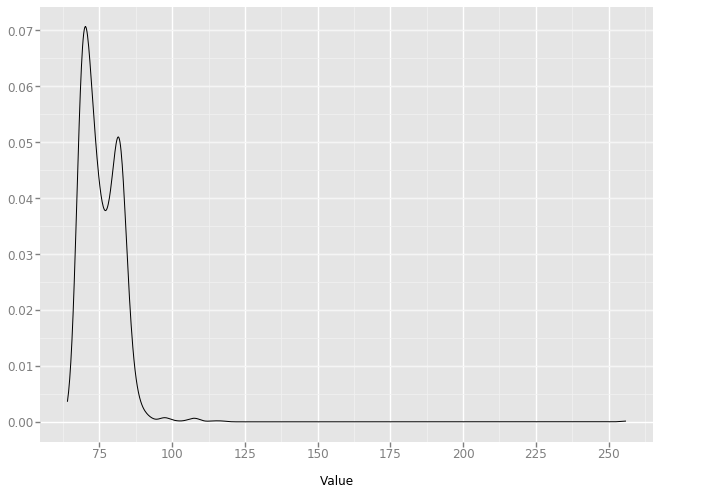

<ggplot: (282612101)>

In [82]:
ggplot(df_sub.loc[(df_sub['Appliance'] == 'fridge') & (df_sub['Value'] > 50) & (df_sub['Value'] < 300)], aes('Value')) + geom_density(adjust = 1/5)